## ETL Y EDA Preliminar de GOOGLE 

### Review ESTADO FLORIDA

Vamos a comenzar a analizar estos archivos, pero para eso hay que tranformar los archivos json a un formato mas manejable. 

Los archivos de los estados de FLORIDA, vinieron 19 archivos comprimidos en varias carpetas, las cuales se descomprimieron y se comenzo con la transformacion.


In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:
with open('../Archivos_texto/review-Florida/1.json', 'r', encoding='utf-8') as file:
    for line in file:
        try:
            data = json.loads(line)
            #print(data)
        except json.JSONDecodeError as e:
            print(f"Error al decodificar JSON en línea: {line}")
            
print(type(data))             

<class 'dict'>


Una vez de que se leyeron y se transformaron los 19 archivos, se concatenaron, creando un solo archivo con 2250000 registros.

In [4]:
df_revgoo = pd.read_csv("../Carpeta_ETL/revgoo_concat.csv")
df_revgoo.head()

,user_id,name,time,rating,text,pics,resp,gmap_id
0,101471856155148729010,Julie A. Gerber,1628003250740,1,Update: Their “reply” to my review amounted to...,NaN,"{'time': 1627042799532, 'text': 'Thank you for...",0x8893863ea87bd5dd:0x9383ebf973e74abb
1,115477234789038326051,Martin Sheffield,1595031217005,5,He's a knowledgeable doctor but the way he run...,NaN,"{'time': 1582464056733, 'text': 'Thank you for...",0x8893863ea87bd5dd:0x9383ebf973e74abb
2,101805010244892834381,Brian Truett,1522924253567,5,"Best doctor I've ever had, I never wait to be ...",NaN,NaN,0x8893863ea87bd5dd:0x9383ebf973e74abb
3,106344422881493743981,Tina Sun,1467907819586,1,I was told he is a good doctor. I was trying t...,NaN,NaN,0x8893863ea87bd5dd:0x9383ebf973e74abb
4,100875113069561776529,James Haynes,1480683415081,5,Takes the time to actually get to know his pat...,NaN,NaN,0x8893863ea87bd5dd:0x9383ebf973e74abb


Se comenzo ha hacer el proceso de ETL, viendo primero la estructura y el tipo de datos del dataframe. para eso se utilizaron distintos metoodos y funciones. "head()", "info(),"shape()","dtypes", etc.
Tambien se va a ver si tenemos elementos nulos por cada una de las columnas usando "isnull()", y si el indice principal tiene datos duplicados con "duplicated()".

In [5]:
df_revgoo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250000 entries, 0 to 2249999
Data columns (total 8 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  object
 1   name     object
 2   time     int64 
 3   rating   int64 
 4   text     object
 5   pics     object
 6   resp     object
 7   gmap_id  object
dtypes: int64(2), object(6)
memory usage: 137.3+ MB


In [6]:
df_revgoo.shape

(2250000, 8)

In [7]:
df_revgoo.isnull().sum()

user_id          0
name            12
time             0
rating           0
text        840556
pics       2167837
resp       1881126
gmap_id          0
dtype: int64

Aca se puede observar que la cantidad de nulos de las columnas "pics", "resp", es del mas del 80% son nulos o sin datos, por eso se procede a eliminar porque no aporta dato para el analisis. "text" es de bastante menos pero es mas del 30%, por lo tanto se va a analizar si se elimina o no. 

In [41]:
columnas_a_eliminar = ['pics', 'resp']
df = df_revgoo.drop(columnas_a_eliminar, axis=1)
df_revgoo = df
df.columns

Index(['user_id', 'name', 'time', 'rating', 'text', 'gmap_id'], dtype='object')

Como la columna "time" esta en formato int64, vamos a transformarla a datetime, para que nos quede de la forma "AAAA-MM-DD HH-MM-SS"

In [42]:
# Convertir la columna 'time' a formato datetime
df_revgoo['time'] = pd.to_datetime(df_revgoo['time'], unit='ms', errors='coerce')

# Aplicar strftime para formatear la fecha sin milisegundos
df_revgoo['time'] = df_revgoo['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Verificar el resultado
print(df_revgoo[['time']].head())

                  time
0  2021-08-03 15:07:30
1  2020-07-18 00:13:37
2  2018-04-05 10:30:53
3  2016-07-07 16:10:19
4  2016-12-02 12:56:55


C:\Users\Esteban\AppData\Local\Temp\ipykernel_9860\1309952723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['year'] = df_filtrado['time'].dt.year


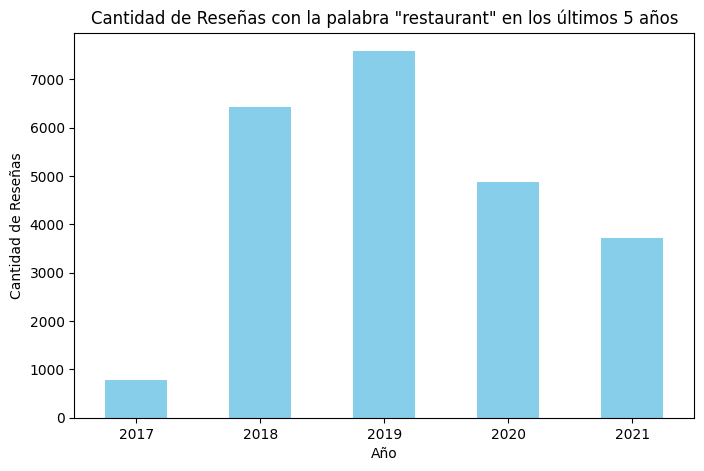

In [43]:
# Paso 1: Asegurarte de que la columna 'time' esté en formato datetime
df_revgoo['time'] = pd.to_datetime(df_revgoo['time'], errors='coerce')

# Paso 2: Filtrar los últimos 5 años
# Obtener la fecha actual
fecha_actual = pd.Timestamp.now()
fecha_inicio = fecha_actual - pd.DateOffset(years=7)

# Filtrar las reseñas de los últimos 5 años
df_ultimos_5_anios = df_revgoo[df_revgoo['time'] >= fecha_inicio]

# Paso 3: Filtrar las filas donde 'text' contiene la palabra 'restaurant' (sin importar mayúsculas/minúsculas)
df_filtrado = df_ultimos_5_anios[df_ultimos_5_anios['text'].str.contains('restaurant', case=False, na=False)]

# Paso 4: Contar la cantidad de reviews por año
df_filtrado['year'] = df_filtrado['time'].dt.year
reviews_por_anio = df_filtrado['year'].value_counts().sort_index()

# Paso 5: Graficar el resultado
plt.figure(figsize=(8, 5))
reviews_por_anio.plot(kind='bar', color='skyblue')

# Agregar títulos y etiquetas
plt.title('Cantidad de Reseñas con la palabra "restaurant" en los últimos 5 años')
plt.xlabel('Año')
plt.ylabel('Cantidad de Reseñas')
plt.xticks(rotation=0)

# Mostrar la gráfica
plt.show()

In [44]:
df_filtrado.shape

(23387, 7)

In [45]:
# Vamos a contar la cantidad de duplicados que hay en la columna "user_id"
num_duplicados = df_revgoo['user_id'].duplicated().sum()
print(f"Total de duplicados en user_id: {num_duplicados}")

Total de duplicados en user_id: 1424119


Vamos a ver si eliminamos o no los duplicados de esta columna, ya que puede ser que sea un indice anidado con otras, como "name" y "time", para que sea unica.

In [46]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
duplicates_check = df_revgoo.duplicated(subset=['user_id', 'name', 'time'])

# Muestra las filas duplicadas en conjunto
print(len(df_revgoo[duplicates_check]))

88286


In [47]:
# Verificar si las combinaciones de 'users', 'name', y 'time' son únicas
unique_combinations = df_revgoo.drop_duplicates(subset=['user_id', 'name', 'time'])
print(unique_combinations.shape)
print(df_revgoo.shape)

(2161714, 6)
(2250000, 6)


In [48]:
# Eliminar duplicados solo en 'users'
df_without_duplicates = df_revgoo.drop_duplicates(subset='user_id')

# Comparar las formas del DataFrame original y el modificado
print("Tamaño original:", df_revgoo.shape)
print("Tamaño sin duplicados en 'user_id':", df_without_duplicates.shape)

Tamaño original: (2250000, 6)
Tamaño sin duplicados en 'user_id': (825881, 6)


## ANALISIS 
"Al analizar los duplicados presentes en la columna "users", observamos que si se eliminan duplicados solo en esa columna, se pierde información valiosa que está relacionada con las columnas name y time. Al realizar un análisis más detallado de la combinación de estas tres columnas, se verificó que la combinación de users, name, y time es única en la mayoría de los casos. Por lo tanto, eliminar duplicados únicamente en la columna users llevaría a una pérdida de datos importantes sobre las interacciones de los usuarios, sus nombres, y los tiempos en que ocurrieron las acciones."

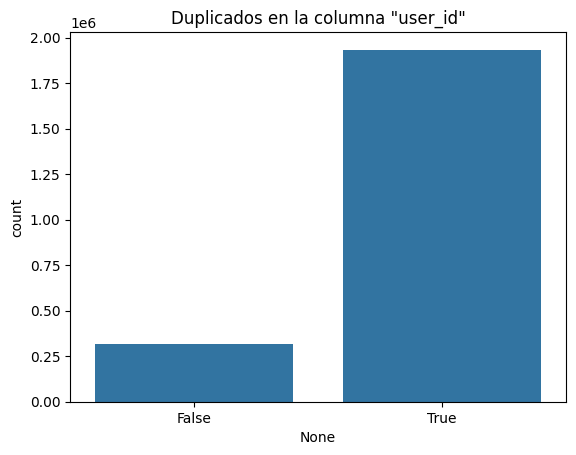

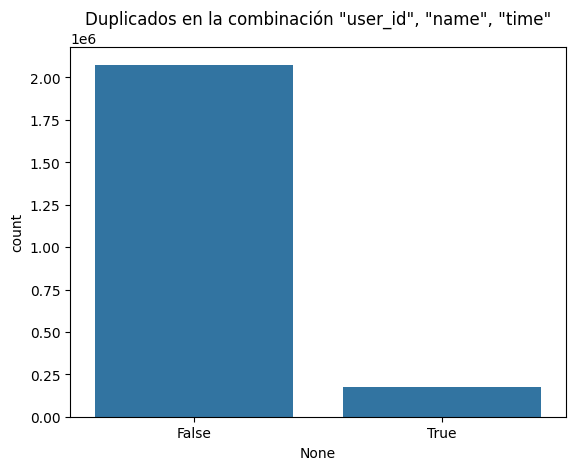

In [49]:
# Comparar el número de duplicados en 'users' vs. las combinaciones únicas
sns.countplot(x=df_revgoo.duplicated(subset='user_id', keep=False))
plt.title('Duplicados en la columna "user_id"')
plt.show()

sns.countplot(x=df_revgoo.duplicated(subset=['user_id', 'name', 'time'], keep=False))
plt.title('Duplicados en la combinación "user_id", "name", "time"')
plt.show()

Vamos a realizar el grafico de barras, para los rating y luego sacar el promedio

rating
1     156457
2      67257
3     166842
4     360887
5    1498557
Name: count, dtype: int64


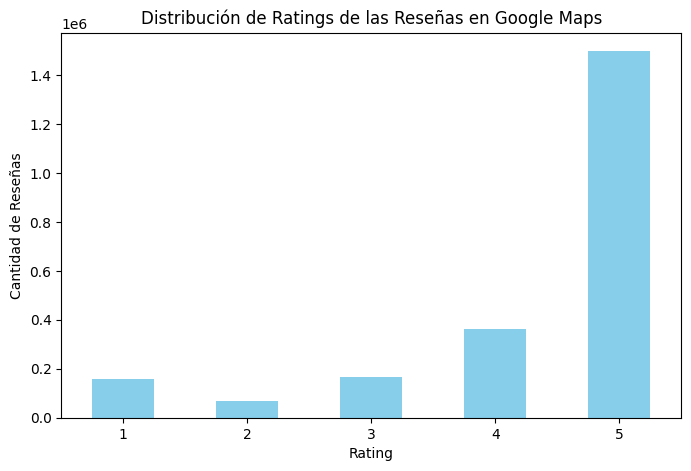

In [50]:
# Contar la cantidad de reviews para cada rating del 1 al 5
rating_counts = df_revgoo['rating'].value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)

# Mostrar los resultados
print(rating_counts)

# Crear un gráfico de barras
plt.figure(figsize=(8, 5))
rating_counts.plot(kind='bar', color='skyblue')

# Agregar títulos y etiquetas
plt.title('Distribución de Ratings de las Reseñas en Google Maps')
plt.xlabel('Rating')
plt.ylabel('Cantidad de Reseñas')
plt.xticks(rotation=0)  # Mantener las etiquetas de los ejes X horizontales

# Mostrar la gráfica
plt.show()

In [51]:
# Contar cuántas filas contienen la palabra "restaurant" en la columna 'text' (sin importar mayúsculas/minúsculas)
restaurant_count = df_revgoo['text'].str.contains('restaurant', case=False, na=False).sum()
rest_amer= df_revgoo['text'].str.contains('american', case=False, na=False).sum()

# Mostrar el resultado
print(f'Cantidad de filas que contienen la palabra "restaurant" y "american": {restaurant_count}, {rest_amer}')

Cantidad de filas que contienen la palabra "restaurant" y "american": 27721, 2660


Vamos a analizar cual es son las palabras que mas se utilizan en una reseña, usando una nube de palabras

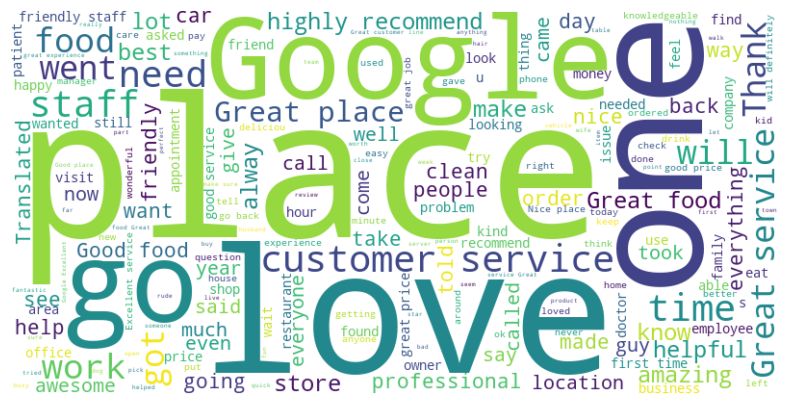

In [26]:
# Verificar que la columna 'text' exista y que su tipo de dato sea object o contenga valores NaN
if 'text' in df_revgoo.columns:
    # Convertir los valores de la columna 'text' a string y reemplazar NaN por una cadena vacía
    df_revgoo['text'] = df_revgoo['text'].fillna('').astype(str)

    # Unir todo el texto en una sola cadena
    texto_total = " ".join(df_revgoo['text'])

    # Crear la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_total)

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
else:
    print("La columna 'text' no existe en el DataFrame.")

In [55]:
df_filtrado.shape
df_filtrado.to_csv("revgoo3_csv.csv")

### Archivo Metadata-Sitios

In [5]:
import os  
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import KMeans

In [6]:
# Función para abrir carpeta de metadata-sitios
def merge_json_files(folder_path):
    merged_data = []  # Lista para almacenar los objetos JSON combinados

    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            filepath = os.path.join(folder_path, filename)
            with open(filepath) as file:
                for line in file:
                    try:
                        obj = json.loads(line)
                        merged_data.append(obj)
                    except json.JSONDecodeError as e:
                        print(f"Error al decodificar JSON en el archivo {filename}: {str(e)}")

    df = pd.DataFrame(merged_data)  # Crear DataFrame a partir de los objetos JSON
    return df

# Ejemplo de uso
folder_path = 'c:/DataScience/Proyecto_Final/metadata-sitios/'
Metadata = merge_json_files(folder_path)


In [7]:
print(Metadata.dtypes)  # Muestra los tipos de datos de cada columna

name                 object
address              object
gmap_id              object
description          object
latitude            float64
longitude           float64
category             object
avg_rating          float64
num_of_reviews        int64
price                object
hours                object
MISC                 object
state                object
relative_results     object
url                  object
dtype: object


In [8]:
Metadata.head()

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Porter Pharmacy,"Porter Pharmacy, 129 N Second St, Cochran, GA ...",0x88f16e41928ff687:0x883dad4fd048e8f8,None,32.388300,-83.357100,[Pharmacy],4.9,16,None,"[[Friday, 8AM–6PM], [Saturday, 8AM–12PM], [Sun...","{'Service options': ['In-store shopping', 'Sam...",Open ⋅ Closes 6PM,"[0x88f16e41929435cf:0x5b2532a2885e9ef6, 0x88f1...",https://www.google.com/maps/place//data=!4m2!3...
1,City Textile,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,None,34.018891,-118.215290,[Textile exporter],4.5,6,None,None,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
2,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,None,34.058092,-118.292130,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...","{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
3,Nova Fabrics,"Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",0x80c2c89923b27a41:0x32041559418d447,None,34.023669,-118.232930,[Fabric store],3.3,6,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
4,Nobel Textile Co,"Nobel Textile Co, 719 E 9th St, Los Angeles, C...",0x80c2c632f933b073:0xc31785961fe826a6,None,34.036694,-118.249421,[Fabric store],4.3,7,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...


In [9]:
Metadata['name'] = Metadata['name'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

Revision de duplicados 

In [37]:
# Contar duplicados en la columna 'name'
cantidad_duplicados = Metadata['name'].duplicated(keep=False).sum()

# Mostrar la cantidad de duplicados
print(f'Cantidad de nombres duplicados: {cantidad_duplicados}')

Cantidad de nombres duplicados: 4693551


Eliminar duplicados 

In [38]:
Metadata.drop_duplicates(subset='name', keep='first', inplace=True)

Tratar Valores Faltantes

In [10]:
# Ver la cantidad de valores faltantes por columna
print(Metadata.isnull().sum())

name                     37
address               80511
gmap_id                   0
description         2770722
latitude                  0
longitude                 0
category              17419
avg_rating                0
num_of_reviews            0
price               2749808
hours                787405
MISC                 690834
state                746455
relative_results     295058
url                       0
dtype: int64


In [11]:
# total_filas es el total de filas en el DataFrame.
total_filas = len(Metadata)

# Calculamos el número de valores faltantes en cada columna.
valores_faltantes = Metadata.isnull().sum()

# Calculamos el porcentaje de valores faltantes para cada columna.
porcentaje_faltante = (valores_faltantes / total_filas) * 100

# Mostramos el resultado en un DataFrame para una mejor visualización.
porcentaje_faltante_df = pd.DataFrame(porcentaje_faltante, columns=['Porcentaje de Valores Faltantes'])
print(porcentaje_faltante_df)


                  Porcentaje de Valores Faltantes
name                                     0.001223
address                                  2.661511
gmap_id                                  0.000000
description                             91.593783
latitude                                 0.000000
longitude                                0.000000
category                                 0.575833
avg_rating                               0.000000
num_of_reviews                           0.000000
price                                   90.902413
hours                                   26.029823
MISC                                    22.837405
state                                   24.676109
relative_results                         9.753948
url                                      0.000000


Eliminacion de columnas : De acuerdo con el resultado obtenido, procedemos con la eliminacion de las columnas description y price ya que mas del 80% de sus valores son nulos. 

In [12]:
Metadata = Metadata.drop(columns=['description', 'price']) 

Eliminacion de filas: En las columnas name, address, category y relative_Result se cuentan con poco datos nulos por lo que procedemos a eliminar la fila. 

In [14]:
Metadata = Metadata.dropna(subset=['name'])
Metadata = Metadata.dropna(subset=['address'])
Metadata = Metadata.dropna(subset=['category'])
etadata = Metadata.dropna(subset=['relative_results'])

Completamos los demas valores faltante con la frase no hay informacion 

In [15]:
Metadata.fillna({
    'hours': 'No hay informacion',
    'Misc': 'No hay informacion',
    'state': 'No hay informacion'
}, inplace=True)

# Verifica los cambios
Metadata.head()

,name,address,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,hours,MISC,state,relative_results,url
0,Porter Pharmacy,"Porter Pharmacy, 129 N Second St, Cochran, GA ...",0x88f16e41928ff687:0x883dad4fd048e8f8,32.388300,-83.357100,[Pharmacy],4.9,16,"[[Friday, 8AM–6PM], [Saturday, 8AM–12PM], [Sun...","{'Service options': ['In-store shopping', 'Sam...",Open ⋅ Closes 6PM,"[0x88f16e41929435cf:0x5b2532a2885e9ef6, 0x88f1...",https://www.google.com/maps/place//data=!4m2!3...
1,City Textile,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,34.018891,-118.215290,[Textile exporter],4.5,6,No hay informacion,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
2,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,34.058092,-118.292130,[Korean restaurant],4.4,18,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...","{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
3,Nova Fabrics,"Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",0x80c2c89923b27a41:0x32041559418d447,34.023669,-118.232930,[Fabric store],3.3,6,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
4,Nobel Textile Co,"Nobel Textile Co, 719 E 9th St, Los Angeles, C...",0x80c2c632f933b073:0xc31785961fe826a6,34.036694,-118.249421,[Fabric store],4.3,7,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...


Normalizamos los textos en columnas como name y  address para evitar inconsistencias

In [16]:
Metadata['name'] = Metadata['name'].str.strip().str.lower()
Metadata['address'] = Metadata['address'].str.strip().str.lower()

Convertir Tipos de Datos

In [17]:
Metadata['avg_rating'] = pd.to_numeric(Metadata['avg_rating'], errors='coerce')

Expandir listas: Para la columna category, consideramos necesario expandir las listas en filas separadas si hay múltiples categorías.

In [18]:
Metadata = Metadata.explode('category')

Ahora exploremos la categoria de restaurantes 

In [19]:
restaurantes= Metadata[(Metadata['category'].str.contains('restaurant', case= False, na=False))]
print(restaurantes)

                                          name  \
2                                 san soo dang   
6                                 vons chicken   
8        sweet rewards gluten free bakery, llc   
68                             vivi bubble tea   
96                                   hale pops   
...                                        ...   
3025004          rosa’s mexican grill chandler   
3025005                         domino's pizza   
3025005                         domino's pizza   
3025005                         domino's pizza   
3025006         the green room of libertyville   

                                                   address  \
2        san soo dang, 761 s vermont ave, los angeles, ...   
6        vons chicken, 12740 la mirada blvd, la mirada,...   
8        sweet rewards gluten free bakery, llc, 85 ne d...   
68       vivi bubble tea, 701 s 5th st, philadelphia, p...   
96        hale pops, 55-370 kamehameha hwy, laie, hi 96762   
...                        

Verificar la Consistencia de las Ubicaciones.
Nos aseguramos de que las latitudes y longitudes estén dentro de los rangos válidos. Por ejemplo, la latitud debe estar entre -90 y 90, y la longitud entre -180 y 180.

In [20]:
Metadata = Metadata[(Metadata['latitude'] >= -90) & (Metadata['latitude'] <= 90)]
Metadata = Metadata[(Metadata['longitude'] >= -180) & (Metadata['longitude'] <= 180)]

Estandarizamos Formatos de Horas: convertimos el formato de hora en un formato mas manejable y acorde con el que venimos manejando HH:MM:SS y desanidamos los dias de la semana 

In [21]:
print(Metadata['hours'].head())


0    [[Friday, 8AM–6PM], [Saturday, 8AM–12PM], [Sun...
1                                   No hay informacion
2    [[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...
3    [[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...
4    [[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...
Name: hours, dtype: object


In [22]:
# Función para convertir horas AM/PM al formato de 24 horas
def convertir_a_24h(hora, periodo):
    if periodo == "AM":
        return "00" if hora == "12" else hora.zfill(2)
    else:
        return hora if hora == "12" else str(int(hora) + 12).zfill(2)

# Función para estandarizar los horarios
def estandarizar_horarios(lista_horarios):
    # Diccionario para guardar horarios de cada día
    dia_a_horas = { 
        "Monday": None, "Tuesday": None, "Wednesday": None,
        "Thursday": None, "Friday": None, "Saturday": None, "Sunday": None 
    }
    
    # Si no hay información, devolver los valores vacíos
    if lista_horarios == "No hay informacion":
        return dia_a_horas

    # Procesar cada entrada de día y horas
    for entrada in lista_horarios:
        if len(entrada) == 2:  # Asegurarse que hay un día y un horario
            dia, horario = entrada
            # Buscar coincidencias con el formato de hora AM/PM
            coincidencia_hora = re.match(r"(\d{1,2}):?(\d{2})?(AM|PM)–(\d{1,2}):?(\d{2})?(AM|PM)", horario)
            if coincidencia_hora:
                hora_inicio, minuto_inicio, periodo_inicio, hora_fin, minuto_fin, periodo_fin = coincidencia_hora.groups()
                minuto_inicio = minuto_inicio or "00"  # Si falta el minuto, poner "00"
                minuto_fin = minuto_fin or "00"        # Si falta el minuto, poner "00"
                # Convertir a formato de 24 horas
                hora_formato_inicio = f"{convertir_a_24h(hora_inicio, periodo_inicio)}:{minuto_inicio}:00"
                hora_formato_fin = f"{convertir_a_24h(hora_fin, periodo_fin)}:{minuto_fin}:00"
                # Guardar el horario convertido
                dia_a_horas[dia] = f"{hora_formato_inicio}-{hora_formato_fin}"
    return dia_a_horas

# Aplicar la función a la columna 'hours'
Metadata['hours'] = Metadata['hours'].apply(estandarizar_horarios)

# Crear columnas separadas para cada día de la semana
for dia in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:
    Metadata[dia] = Metadata['hours'].apply(lambda x: x[dia])

# Verificar los cambios
Metadata.head()

,name,address,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,hours,MISC,state,relative_results,url,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,porter pharmacy,"porter pharmacy, 129 n second st, cochran, ga ...",0x88f16e41928ff687:0x883dad4fd048e8f8,32.388300,-83.357100,Pharmacy,4.9,16,"{'Monday': '08:00:00-18:00:00', 'Tuesday': '08...","{'Service options': ['In-store shopping', 'Sam...",Open ⋅ Closes 6PM,"[0x88f16e41929435cf:0x5b2532a2885e9ef6, 0x88f1...",https://www.google.com/maps/place//data=!4m2!3...,08:00:00-18:00:00,08:00:00-18:00:00,08:00:00-12:00:00,08:00:00-18:00:00,08:00:00-18:00:00,08:00:00-12:00:00,None
1,city textile,"city textile, 3001 e pico blvd, los angeles, c...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,34.018891,-118.215290,Textile exporter,4.5,6,"{'Monday': None, 'Tuesday': None, 'Wednesday':...",None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,None,None,None,None,None,None,None
2,san soo dang,"san soo dang, 761 s vermont ave, los angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,34.058092,-118.292130,Korean restaurant,4.4,18,"{'Monday': None, 'Tuesday': '06:30:00-18:00:00...","{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,None,06:30:00-18:00:00,06:30:00-18:00:00,06:30:00-18:00:00,06:30:00-18:00:00,06:30:00-18:00:00,07:00:00-12:00:00
3,nova fabrics,"nova fabrics, 2200 e 11th st, los angeles, ca ...",0x80c2c89923b27a41:0x32041559418d447,34.023669,-118.232930,Fabric store,3.3,6,"{'Monday': '09:00:00-17:00:00', 'Tuesday': '09...","{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,09:00:00-17:00:00,09:00:00-17:00:00,09:00:00-17:00:00,09:00:00-17:00:00,09:00:00-17:00:00,None,None
4,nobel textile co,"nobel textile co, 719 e 9th st, los angeles, c...",0x80c2c632f933b073:0xc31785961fe826a6,34.036694,-118.249421,Fabric store,4.3,7,"{'Monday': '09:00:00-17:00:00', 'Tuesday': '09...",{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,09:00:00-17:00:00,09:00:00-17:00:00,09:00:00-17:00:00,09:00:00-17:00:00,09:00:00-17:00:00,None,None


### Nuestro interes se centra unicamente en el estado de Florida. Por lo tanto procedemos hacer la limpieza de datos dejando unicamente los datos de este estado. 

In [23]:
# Filtrar por el rango de latitud y longitud de Florida
florida_metadata = Metadata[
    (Metadata['latitude'] >= 24.396308) &
    (Metadata['latitude'] <= 31.000000) &
    (Metadata['longitude'] >= -87.634938) &
    (Metadata['longitude'] <= -79.974307)
]

# Ver los datos filtrados
print(florida_metadata)


                                      name  \
14                             ntk outdoor   
45           cruises inc. - connie stewart   
87       first impressions barbershop inc.   
105                      brian shaheen, md   
105                      brian shaheen, md   
...                                    ...   
3024965                              jared   
3024965                              jared   
3024965                              jared   
3024966         whispering creek co-op inc   
3024966         whispering creek co-op inc   

                                                   address  \
14       ntk outdoor, 2315 nw 107th ave #1b18, miami, f...   
45       cruises inc. - connie stewart, 6602 52nd ln, p...   
87       first impressions barbershop inc., 577 deltona...   
105      brian shaheen, md, 2421 thomas dr, panama city...   
105      brian shaheen, md, 2421 thomas dr, panama city...   
...                                                    ...   
3024965  jare

Ahora revisaremos los datos para los restaurantes de florida 

In [24]:
# Filtrar solo los restaurantes en Florida
florida_restaurants = florida_metadata[
    florida_metadata['category'].str.contains('restaurant', case=False, na=False)
]

# Ver los datos filtrados
print(florida_restaurants)

                                                      name  \
114                                     cape seafood shack   
115                             fresh point country buffet   
674                                                hot box   
904      gormley's on the river | modern cuisine in his...   
904      gormley's on the river | modern cuisine in his...   
...                                                    ...   
3023744                                    super taquerias   
3023855                           timeless - an mhk eatery   
3024020                             a taste of new orleans   
3024439                                  just fish & grits   
3024720                rainforest cafe shop-animal kingdom   

                                                   address  \
114      cape seafood shack, 603 del prado blvd s, cape...   
115      fresh point country buffet, 10525 us-19, pinel...   
674          hot box, 1-99 kinkaid st, pensacola, fl 32507   
904    

In [25]:
# Contar la cantidad de restaurantes por categoría y seleccionar el top 20
top_20_restaurant_types = florida_restaurants['category'].value_counts().head(20)

# Ver los resultados
print(top_20_restaurant_types)


category
Restaurant                   6834
Fast food restaurant         1716
Takeout Restaurant           1304
Pizza restaurant             1287
American restaurant          1097
Breakfast restaurant          923
Italian restaurant            681
Seafood restaurant            675
Mexican restaurant            673
Delivery Restaurant           609
Chinese restaurant            582
Hamburger restaurant          467
Health food restaurant        402
Family restaurant             389
Asian restaurant              323
Sushi restaurant              312
Latin American restaurant     305
Barbecue restaurant           304
Chicken wings restaurant      282
Vegan restaurant              267
Name: count, dtype: int64


C:\Users\Usuario\AppData\Local\Temp\ipykernel_51904\2733390903.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_restaurant_types.values, y=top_20_restaurant_types.index, palette='viridis')


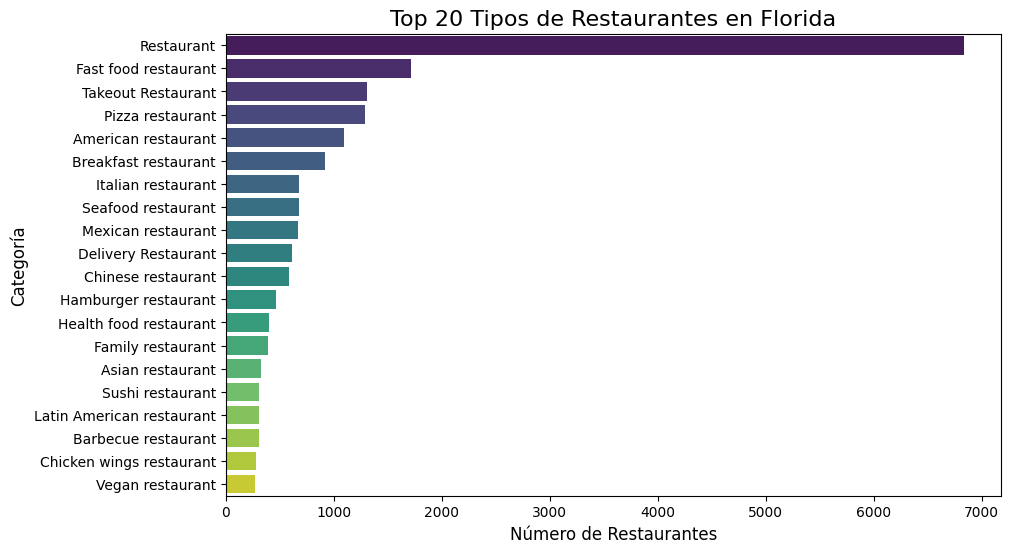

In [26]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear gráfico de barras con Seaborn
sns.barplot(x=top_20_restaurant_types.values, y=top_20_restaurant_types.index, palette='viridis')

# Títulos y etiquetas
plt.title('Top 20 Tipos de Restaurantes en Florida', fontsize=16)
plt.xlabel('Número de Restaurantes', fontsize=12)
plt.ylabel('Categoría', fontsize=12)

# Mostrar gráfico
plt.show()

### Análisis de Restaurantes en Florida

In [27]:
# Ver el número de filas y columnas
filas, columnas = florida_restaurants.shape
print(f"Número de filas: {filas}")
print(f"Número de columnas: {columnas}")

Número de filas: 25370
Número de columnas: 20


In [28]:
# 1. Promedio de Calificaciones
promedio_calificaciones = florida_restaurants['avg_rating'].mean()
print(f'Calificación promedio: {promedio_calificaciones}')

Calificación promedio: 4.119641308632244


C:\Users\Usuario\AppData\Local\Temp\ipykernel_51904\1939826711.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y='category', data=promedio_calificaciones_top_20, palette='viridis')


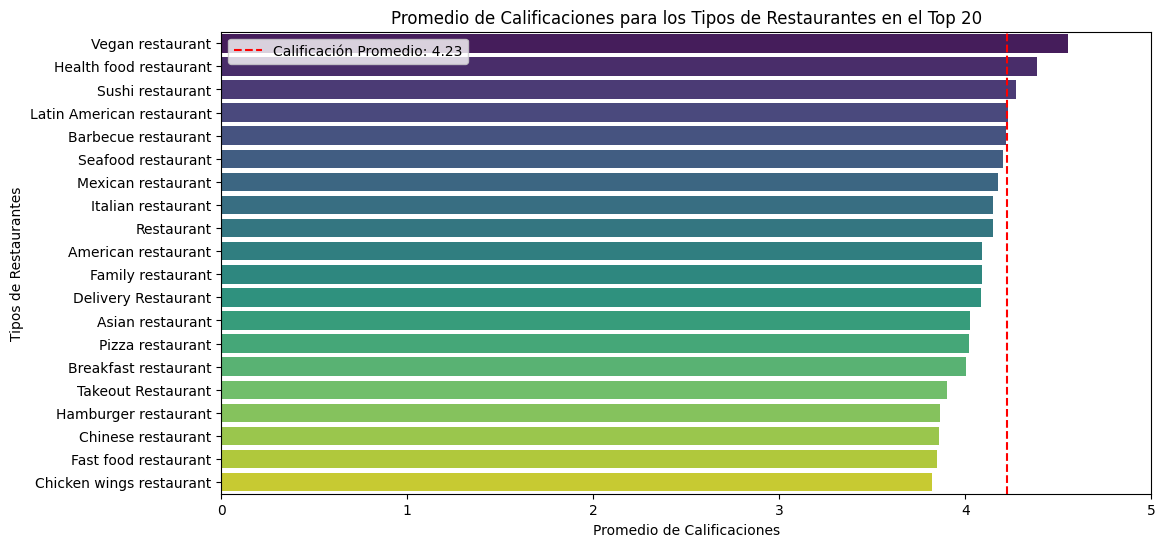

In [29]:
# Contar la cantidad de restaurantes por categoría y seleccionar el top 20
top_20_restaurant_types = florida_restaurants['category'].value_counts().head(20).index

# Filtrar el DataFrame para incluir solo los restaurantes en el top 20
filtered_restaurants = florida_restaurants[florida_restaurants['category'].isin(top_20_restaurant_types)]

# Calcular el promedio de calificaciones para cada tipo de restaurante en el top 20
promedio_calificaciones_top_20 = filtered_restaurants.groupby('category')['avg_rating'].mean().reset_index()

# Ordenar los valores para la gráfica
promedio_calificaciones_top_20 = promedio_calificaciones_top_20.sort_values(by='avg_rating', ascending=False)

# Calificación promedio general
calificacion_promedio = 4.225110242116648

# Crear la gráfica
plt.figure(figsize=(12, 6))
sns.barplot(x='avg_rating', y='category', data=promedio_calificaciones_top_20, palette='viridis')
plt.axvline(x=calificacion_promedio, color='red', linestyle='--', label='Calificación Promedio: {:.2f}'.format(calificacion_promedio))
plt.title('Promedio de Calificaciones para los Tipos de Restaurantes en el Top 20')
plt.xlabel('Promedio de Calificaciones')
plt.ylabel('Tipos de Restaurantes')
plt.xlim(0, 5)  # Limitar el eje x de 0 a 5 si es necesario
plt.legend()  # Mostrar leyenda
plt.show()

### Análisis Geográfico

#### Puntos azules: Estos representan restaurantes que tienen una calificación promedio de 4 o más.
#### Puntos rojos: Estos puntos indican restaurantes que tienen una calificación promedio inferior a 4.

#### Nos permite visualizar rápidamente en el mapa qué áreas de Florida tienen restaurantes de alta calidad (puntos azules) y cuáles tienen restaurantes que podrían necesitar mejoras (puntos rojos).

In [31]:
# Crear un mapa de calor de las calificaciones
m = folium.Map(location=[27.9944024, -81.7602544], zoom_start=6)  # Centro de Florida

for _, restaurant in florida_restaurants.iterrows():
    folium.CircleMarker(
        location=(restaurant['latitude'], restaurant['longitude']),
        radius=5,
        color='blue' if restaurant['avg_rating'] >= 4 else 'red',
        fill=True,
        fill_color='blue' if restaurant['avg_rating'] >= 4 else 'red',
        fill_opacity=0.6,
        popup=restaurant['name']
    ).add_to(m)

m.save('mapa_restaurantes_florida.html')


### Ahora visualicemos unicamente los restaurantes de comida tipo americana 

In [33]:
# Filtra los restaurantes de comida americana
american_restaurants = florida_restaurants[florida_restaurants['category'].str.contains('American', case=False, na=False)]

# Crear un mapa centrado en Florida
m = folium.Map(location=[27.9944024, -81.7602544], zoom_start=6)

# Añadir marcadores al mapa
for _, restaurant in american_restaurants.iterrows():
    folium.CircleMarker(
        location=(restaurant['latitude'], restaurant['longitude']),
        radius=5,
        color='blue' if restaurant['avg_rating'] >= 4 else 'red',
        fill=True,
        fill_color='blue' if restaurant['avg_rating'] >= 4 else 'red',
        fill_opacity=0.6,
        popup=f"{restaurant['name']} (Rating: {restaurant['avg_rating']})"
    ).add_to(m)

# Guardar el mapa como archivo HTML
m.save('mapa_american_restaurants_florida.html')

La zona de mayor puntaje

In [34]:
# Aplicar KMeans clustering
num_clusters = 10  # Elige el número de clusters según convenga
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
american_restaurants['cluster'] = kmeans.fit_predict(american_restaurants[['latitude', 'longitude']])

# Calcular el promedio de estrellas por cluster
cluster_means = american_restaurants.groupby('cluster')['avg_rating'].mean()
print(cluster_means)

# Identificar el cluster con la mejor calificación promedio
best_cluster = cluster_means.idxmax()
print(f"El cluster con la mejor calificación es: {best_cluster}")

# Filtrar los restaurantes en el mejor cluster
best_cluster_restaurants = american_restaurants[american_restaurants['cluster'] == best_cluster]

# Crear un mapa centrado en el mejor cluster
m = folium.Map(location=[
    best_cluster_restaurants['latitude'].mean(), 
    best_cluster_restaurants['longitude'].mean()
], zoom_start=12)

# Añadir restaurantes del mejor cluster al mapa
for _, restaurant in best_cluster_restaurants.iterrows():
    folium.CircleMarker(
        location=(restaurant['latitude'], restaurant['longitude']),
        radius=5,
        color='blue' if restaurant['avg_rating'] >= 4 else 'red',
        fill=True,
        fill_color='blue' if restaurant['avg_rating'] >= 4 else 'red',
        fill_opacity=0.6,
        popup=restaurant['name']
    ).add_to(m)

m.save('mapa_mejor_cluster_american_restaurants.html')


cluster
0    4.209333
1    4.137293
2    4.083099
3    4.104598
4    4.130769
5    4.236667
6    4.104969
7    4.018182
8    4.123256
9    4.117178
Name: avg_rating, dtype: float64
El cluster con la mejor calificación es: 5


C:\Users\Usuario\AppData\Local\Temp\ipykernel_51904\3547825281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  american_restaurants['cluster'] = kmeans.fit_predict(american_restaurants[['latitude', 'longitude']])


#### La zona de mayor puntaje corresponde a la región de los Cayos de Florida.

### Análisis de Servicios

C:\Users\Usuario\AppData\Local\Temp\ipykernel_51904\2216249967.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_servicios.values, y=conteo_servicios.index, palette='viridis')


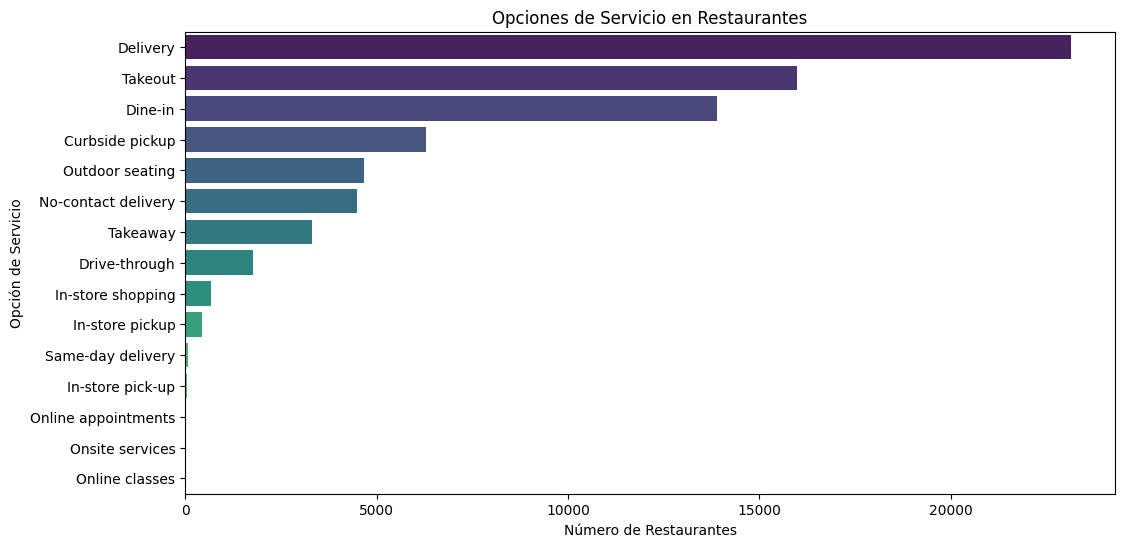

In [35]:
# Analizar las opciones de servicio
servicios = florida_restaurants['MISC'].apply(lambda x: x.get('Service options', []) if isinstance(x, dict) else [])
servicios_flat = [item for sublist in servicios for item in sublist]

# Contar opciones de servicio
conteo_servicios = pd.Series(servicios_flat).value_counts()

# Gráfico de opciones de servicio
plt.figure(figsize=(12, 6))
sns.barplot(x=conteo_servicios.values, y=conteo_servicios.index, palette='viridis')
plt.title('Opciones de Servicio en Restaurantes')
plt.xlabel('Número de Restaurantes')
plt.ylabel('Opción de Servicio')
plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_51904\618075103.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_servicios.values, y=conteo_servicios.index, palette='viridis')


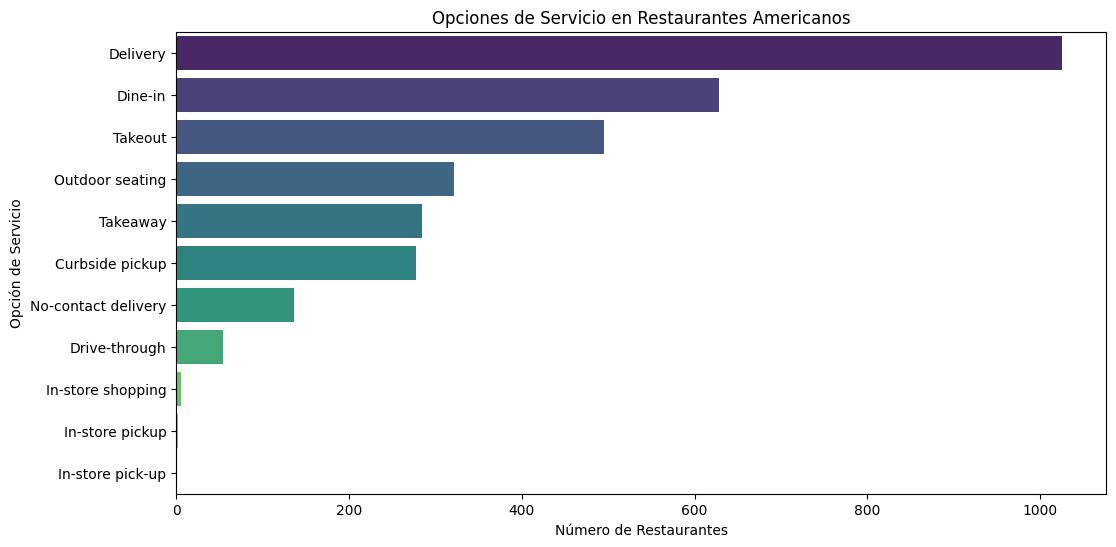

In [36]:
# Filtrar solo los restaurantes de categoría "American restaurant"
american_restaurants = florida_restaurants[florida_restaurants['category'] == 'American restaurant']

# Analizar las opciones de servicio
servicios = american_restaurants['MISC'].apply(lambda x: x.get('Service options', []) if isinstance(x, dict) else [])
servicios_flat = [item for sublist in servicios for item in sublist]

# Contar opciones de servicio
conteo_servicios = pd.Series(servicios_flat).value_counts()

# Gráfico de opciones de servicio
plt.figure(figsize=(12, 6))
sns.barplot(x=conteo_servicios.values, y=conteo_servicios.index, palette='viridis')
plt.title('Opciones de Servicio en Restaurantes Americanos')
plt.xlabel('Número de Restaurantes')
plt.ylabel('Opción de Servicio')
plt.show()